<a href="https://colab.research.google.com/github/SadiyaMayat/LSTM-Model/blob/main/MRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import math

In [ ]:
# Load the data
data = pd.read_csv('/content/MRF.NS.csv')

data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-01,67299.000000,67299.000000,66500.351563,66801.203125,66330.242188,4193
1,2019-01-02,66500.000000,67100.000000,66150.703125,66635.500000,66165.695313,7531
2,2019-01-03,66750.000000,67400.000000,66458.703125,66818.250000,66347.171875,4603
3,2019-01-04,66999.703125,67349.898438,66201.046875,66603.148438,66133.578125,4278
4,2019-01-07,67100.000000,67345.898438,66666.148438,66978.546875,66506.328125,6823


In [ ]:
# Select the relevant features
features = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-01,67299.000000,67299.000000,66500.351563,66801.203125,66330.242188,4193
1,2019-01-02,66500.000000,67100.000000,66150.703125,66635.500000,66165.695313,7531
2,2019-01-03,66750.000000,67400.000000,66458.703125,66818.250000,66347.171875,4603
3,2019-01-04,66999.703125,67349.898438,66201.046875,66603.148438,66133.578125,4278
4,2019-01-07,67100.000000,67345.898438,66666.148438,66978.546875,66506.328125,6823
...,...,...,...,...,...,...,...
1326,2024-05-17,128900.000000,129589.148438,128400.000000,129143.601563,129143.601563,9747
1327,2024-05-21,127560.000000,129992.296875,127560.000000,129620.750000,129620.750000,7993
1328,2024-05-22,129650.000000,130200.000000,129000.000000,129481.250000,129481.250000,7108
1329,2024-05-23,129481.250000,130585.000000,129051.046875,130160.750000,130160.750000,11228


In [ ]:
# Normalize the features using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

In [ ]:
# Create the array for input and output sequence
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 0])  # We want to predict the 'Open' price
    return np.array(X), np.array(y)

time_step = 60
X, y = create_sequences(scaled_features, time_step)

In [ ]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(889, 60, 6)
(381, 60, 6)
(889,)
(381,)


In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            11400     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 32901 (128.52 KB)
Trainable params: 32901 (128.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Implement early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=1, callbacks=[early_stop])

Epoch 1/100
28/28 [==============================] - 6s 47ms/step - loss: 0.0080 - val_loss: 0.0052
Epoch 2/100
28/28 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0074
Epoch 3/100
28/28 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 4/100
28/28 [==============================] - 0s 11ms/step - loss: 9.8031e-04 - val_loss: 0.0036
Epoch 5/100
28/28 [==============================] - 0s 11ms/step - loss: 9.2584e-04 - val_loss: 0.0018
Epoch 6/100
28/28 [==============================] - 0s 12ms/step - loss: 8.4345e-04 - val_loss: 0.0036
Epoch 7/100
28/28 [==============================] - 0s 11ms/step - loss: 8.0698e-04 - val_loss: 0.0024
Epoch 8/100
28/28 [==============================] - 0s 11ms/step - loss: 6.7272e-04 - val_loss: 0.0016
Epoch 9/100
28/28 [==============================] - 0s 11ms/step - loss: 6.4113e-04 - val_loss: 0.0037
Epoch 10/100
28/28 [==============================] - 0s 11ms/step - loss: 5

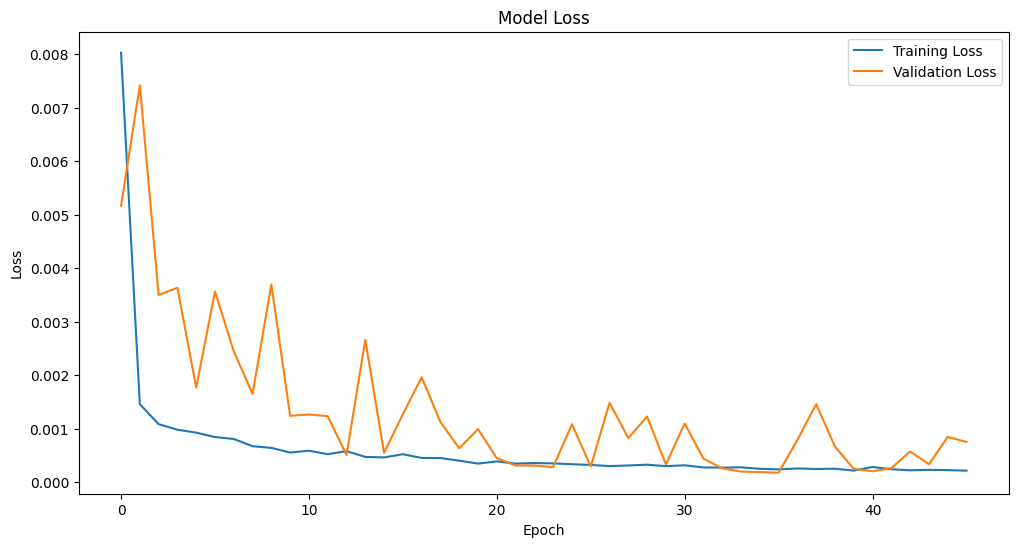

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

12/12 [==============================] - 1s 5ms/step
Mean Squared Error (MSE): 1793858.814100209
Root Mean Squared Error (RMSE): 1339.350146190386


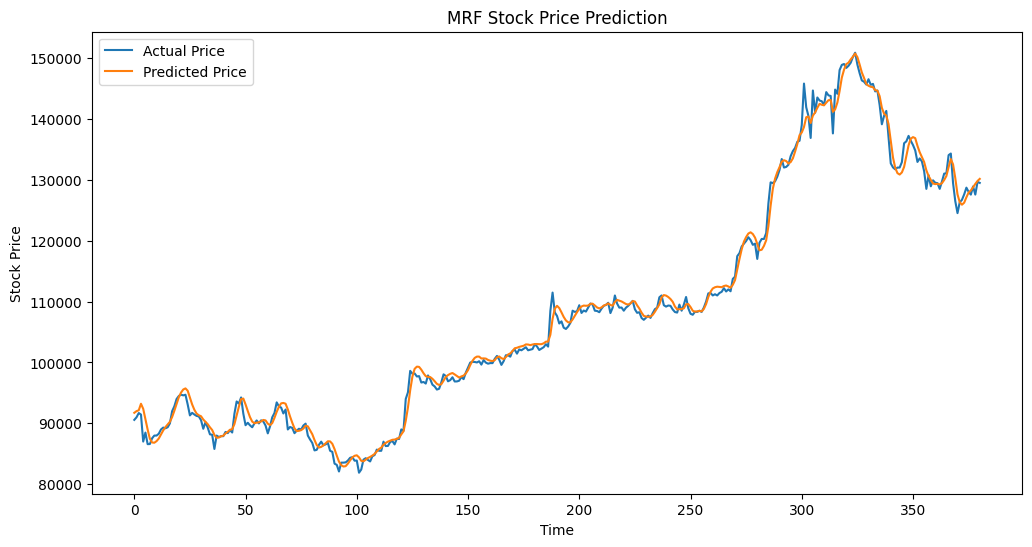

In [ ]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Invert the scaling to get the actual prices
scaler_for_inverse = MinMaxScaler(feature_range=(0, 1))
scaler_for_inverse.fit_transform(features[['Open']])
predictions = scaler_for_inverse.inverse_transform(predictions.reshape(-1, 1))

# Get the actual open prices
actual_prices = scaler_for_inverse.inverse_transform(y_test.reshape(-1, 1))

# Calculate MSE and RMSE
mse = mean_squared_error(actual_prices, predictions)
rmse = math.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('MRF Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
# Predict the next day's open price
last_sequence = scaled_features[-time_step:]
last_sequence = last_sequence.reshape((1, time_step, X_train.shape[2]))
next_day_prediction = model.predict(last_sequence)
next_day_prediction = scaler_for_inverse.inverse_transform(next_day_prediction)

print(f"Predicted Open Price for the next day: {next_day_prediction[0][0]}")

1/1 [==============================] - 0s 40ms/step
Predicted Open Price for the next day: 130973.25
